In [18]:
import pandas as pd
import fasttext
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
# get the df with the posts, tokenized posts, birth years, and binary birth years
df_birth_year = pd.read_csv('data/birth_year.csv')
mil_and_genz = df_birth_year[(1986 < df_birth_year['birth_year']) & (df_birth_year['birth_year'] <= 2006)]
mil_and_genz['binary_birth_year'] = 1
mil_and_genz.loc[(1996 < mil_and_genz['birth_year']) & (mil_and_genz['birth_year'] <= 2006), 'binary_birth_year'] = 0
mil_and_genz = mil_and_genz.reset_index(drop=True)
mil_and_genz

# underample the minority class
undersampled_df = pd.concat([
    resample(mil_and_genz[mil_and_genz['binary_birth_year'] == 1],
             replace=False,
             n_samples=len(mil_and_genz[mil_and_genz['binary_birth_year'] == 0]),
             random_state=42),
    mil_and_genz[mil_and_genz['binary_birth_year'] == 0]
])

# shuffle the dataframe
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

undersampled_df

# tokenization
mil_and_genz['post_tokenized'] = mil_and_genz.post.str.findall('\w+|[^\w\s]')
mil_and_genz

<ipython-input-5-e67fa423ed4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mil_and_genz['binary_birth_year'] = 1
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,auhtor_ID,post,birth_year,binary_birth_year,post_tokenized
0,t2_rnjzutp,Good on you for being responsible! I know self...,2001,0,"[Good, on, you, for, being, responsible, !, I,..."
1,t2_rnjzutp,"must go to the grocery store with their child,...",2001,0,"[must, go, to, the, grocery, store, with, thei..."
2,t2_rnjzutp,"things on her videos, and YouTube took the vid...",2001,0,"[things, on, her, videos, ,, and, YouTube, too..."
3,t2_rnjzutp,their app. There's also a program called SYNC ...,2001,0,"[their, app, ., There, ', s, also, a, program,..."
4,t2_rnjzutp,"side. If the cops don't take your side, you'll...",2001,0,"[side, ., If, the, cops, don, ', t, take, your..."
...,...,...,...,...,...
25450,t2_ef4dv976,clever political meme on a sub about political...,1989,1,"[clever, political, meme, on, a, sub, about, p..."
25451,t2_7ps3a,Kevin. Glück gehabt. I will try! Thank you! I ...,1992,1,"[Kevin, ., Glück, gehabt, ., I, will, try, !, ..."
25452,t2_7ps3a,Handy/der Cloud speichern und in der Kamera ha...,1992,1,"[Handy, /, der, Cloud, speichern, und, in, der..."
25453,t2_7ps3a,that. :)) On Google I cant find much informati...,1992,1,"[that, ., :, ), ), On, Google, I, cant, find, ..."


In [10]:
# concatenate all posts into a single string and save
corpus = " ".join([" ".join(post) for post in mil_and_genz['post_tokenized']])
with open("data/temp_corpus.txt", "w", encoding="utf-8") as file:
    file.write(corpus)

# fastText word embeddings
model = fasttext.train_unsupervised("data/temp_corpus.txt")
model.save_model("result/trained_fasttext_embeddings.bin")

# load the trained model
model = fasttext.load_model("result/trained_fasttext_embeddings.bin")

ValueError: result/trained_fasttext_embeddings.bin cannot be opened for saving!

In [13]:
# get the average embedding for a post (document embedding)
def get_average_embedding(tokens, model):
    embeddings = [model.get_word_vector(word) for word in tokens if word in model.words]
    if embeddings:
        avg_embedding = np.mean(embeddings, axis=0)
    else:
        avg_embedding = np.zeros(model.get_dimension())  # Default to zero if no embeddings found
    return avg_embedding

mil_and_genz['doc_embedding'] = mil_and_genz['post_tokenized'].apply(lambda x: get_average_embedding(x, model))

In [53]:
X_embeddings = np.vstack(mil_and_genz['doc_embedding'].to_numpy())
X = np.hstack([X_embeddings])
y = mil_and_genz['binary_birth_year']

# train a simple logistic regression on this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_rep)

Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.42      0.54      1946
           1       0.72      0.92      0.81      3145

    accuracy                           0.73      5091
   macro avg       0.75      0.67      0.68      5091
weighted avg       0.74      0.73      0.71      5091



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


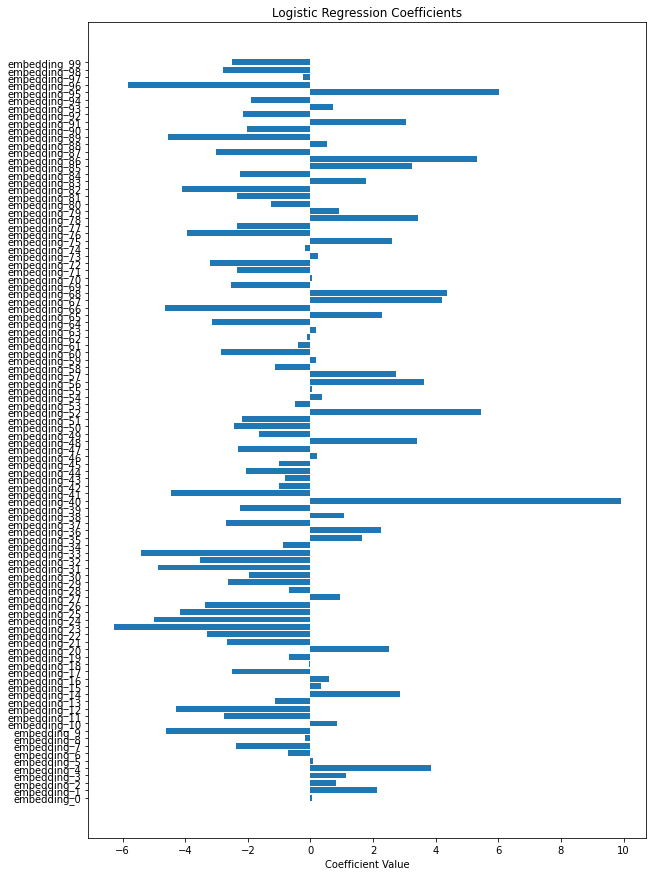

In [56]:
# Get coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names_embeddings = [f'embedding_{i}' for i in range(X_embeddings.shape[1])]
feature_names = feature_names_embeddings

# Plot coefficients
plt.figure(figsize=(10, 15))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(coefficients)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [50]:
coefficients

array([ 0.04191265,  2.12906774,  0.80362033,  1.12053622,  3.86319417,
        0.08664051, -0.73175628, -2.37048838, -0.16121018, -4.60185808,
        0.83314153, -2.77168284, -4.2994166 , -1.12802978,  2.85061744,
        0.34115991,  0.57675193, -2.51107046, -0.0610919 , -0.68621817,
        2.50924886, -2.66605827, -3.29343293, -6.28011593, -4.99430891,
       -4.15505473, -3.37212976,  0.92970605, -0.69445853, -2.62528678,
       -1.976344  , -4.88349648, -3.51968334, -5.40969986, -0.86313015,
        1.64877836,  2.25174557, -2.70804768,  1.06222843, -2.26305245,
        9.91909093, -4.46823565, -1.00327218, -0.80924953, -2.04507489,
       -1.00853064,  0.19758448, -2.31487049,  3.41587174, -1.6379925 ,
       -2.43818299, -2.19566122,  5.45008107, -0.47850792,  0.35600997,
        0.03742352,  3.62521851,  2.73360276, -1.14408487,  0.1747263 ,
       -2.86562964, -0.40481113, -0.11737007,  0.18237337, -3.15904607,
        2.29221651, -4.6513437 ,  4.19782208,  4.36384955, -2.55

# adding doc length

In [20]:
# document length
def count_words(tokens):
    return sum(1 for token in tokens if token.isalpha())
mil_and_genz['doc_length'] = mil_and_genz['post_tokenized'].apply(count_words)
mil_and_genz

,auhtor_ID,post,birth_year,binary_birth_year,post_tokenized,doc_embedding,doc_length
0,t2_rnjzutp,Good on you for being responsible! I know self...,2001,0,"[Good, on, you, for, being, responsible, !, I,...","[0.11057477, -0.07300206, 0.17103024, 0.174696...",1550
1,t2_rnjzutp,"must go to the grocery store with their child,...",2001,0,"[must, go, to, the, grocery, store, with, thei...","[0.09588171, -0.0636309, 0.15638632, 0.1846407...",1560
2,t2_rnjzutp,"things on her videos, and YouTube took the vid...",2001,0,"[things, on, her, videos, ,, and, YouTube, too...","[0.09884542, -0.050419975, 0.17008749, 0.17304...",1542
3,t2_rnjzutp,their app. There's also a program called SYNC ...,2001,0,"[their, app, ., There, ', s, also, a, program,...","[0.08549222, -0.04508631, 0.16294797, 0.195557...",1567
4,t2_rnjzutp,"side. If the cops don't take your side, you'll...",2001,0,"[side, ., If, the, cops, don, ', t, take, your...","[0.090515696, -0.04649129, 0.15880631, 0.19937...",1552
...,...,...,...,...,...,...,...
25450,t2_ef4dv976,clever political meme on a sub about political...,1989,1,"[clever, political, meme, on, a, sub, about, p...","[0.11957115, -0.068640284, 0.15908417, 0.19622...",1074
25451,t2_7ps3a,Kevin. Glück gehabt. I will try! Thank you! I ...,1992,1,"[Kevin, ., Glück, gehabt, ., I, will, try, !, ...","[0.033192165, 0.07978121, 0.013803762, 0.40414...",1484
25452,t2_7ps3a,Handy/der Cloud speichern und in der Kamera ha...,1992,1,"[Handy, /, der, Cloud, speichern, und, in, der...","[0.0081666885, 0.08398565, -0.002547508, 0.429...",1490
25453,t2_7ps3a,that. :)) On Google I cant find much informati...,1992,1,"[that, ., :, ), ), On, Google, I, cant, find, ...","[0.011980573, 0.15330644, -0.08797596, 0.53409...",1504


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1946
           1       0.62      1.00      0.76      3145

    accuracy                           0.62      5091
   macro avg       0.31      0.50      0.38      5091
weighted avg       0.38      0.62      0.47      5091



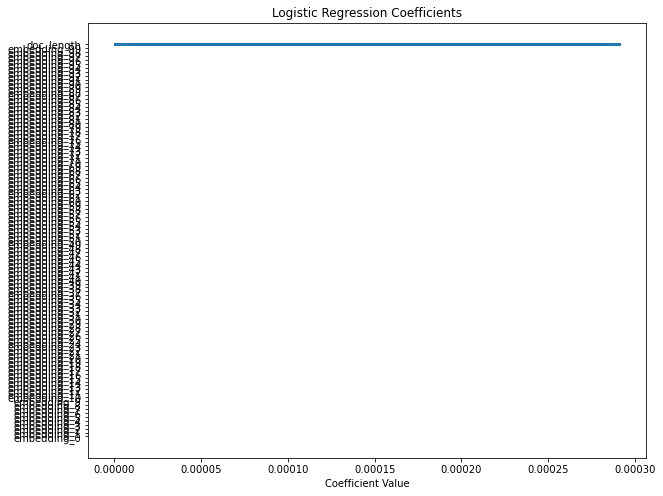

In [51]:
X_embeddings = np.vstack(mil_and_genz['doc_embedding'].to_numpy())
X_doc_length = mil_and_genz['doc_length'].to_numpy().reshape(-1, 1)
X = np.hstack([X_embeddings, X_doc_length])
y = mil_and_genz['binary_birth_year']

# train a simple logistic regression on this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_rep)

# Get coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names_embeddings = [f'embedding_{i}' for i in range(X_embeddings.shape[1])]
feature_names = feature_names_embeddings + ['doc_length']

# Plot coefficients
plt.figure(figsize=(10, 8))
plt.barh(range(len(coefficients)), coefficients, align='center')
plt.yticks(range(len(coefficients)), feature_names)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [52]:
coefficients

array([ 6.30005020e-09,  2.69984343e-08,  2.12216458e-08,  5.86995492e-08,
       -2.71325677e-08,  3.12635938e-08, -3.09392381e-08, -7.15435060e-08,
        1.69957010e-08,  3.23137171e-09,  1.12950057e-08,  3.63389236e-08,
       -5.81188879e-08,  5.21968590e-08, -1.12305346e-08,  3.00588499e-08,
        5.95639849e-09, -1.58978933e-08, -2.94782179e-08, -2.55341794e-09,
       -2.79013328e-08, -1.80407070e-08,  4.70352121e-08, -3.50815752e-08,
       -1.15926465e-07,  2.93600696e-08, -6.49625990e-08,  3.93472722e-08,
        2.93086517e-08, -3.52813759e-08, -4.88756674e-08,  3.66984854e-08,
       -3.63675817e-08, -2.05940806e-08,  1.20152997e-08,  1.27492383e-08,
        3.83931014e-08, -3.92240652e-08,  2.76653413e-09,  8.72724392e-09,
        9.33716169e-09, -3.05016654e-08, -1.79425680e-08, -1.06598800e-08,
       -2.25754506e-08,  2.17211155e-08, -4.54923663e-08,  3.61537422e-09,
       -3.33135666e-08, -2.41980178e-08, -3.31553869e-08, -4.16252691e-08,
        3.22171884e-08,  